In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
import scipy

In [2]:
def pf(x, model, mean=None, cov=None, l=0):
    # model = gp.output[0].model
    kern = model.kern
    X = model.X
    #x = np.array(x).reshape(-1, 1)
    
    #if (mean is None) and (cov is None):
    mean, cov = model.predict(x, full_cov=True)
    
#     print("mean",mean)
    var = np.diag(cov).reshape(-1, 1)
    std = np.sqrt(var).reshape(-1, 1)
    aux_std = np.reciprocal(std)
    aux_var = np.reciprocal(var)
    mean = mean.reshape(-1, 1)
#     print("mean", mean.shape,"var", var.shape)
    norm = scipy.stats.norm(mean, np.sqrt(var))
    fz = norm.pdf(l)
    Fz = norm.cdf(l)
    grad_mean , grad_var = model.predictive_gradients(x)
    grad_std = (1/2.0)*grad_var

    # cov = kern.K(X, X) + np.eye(X.shape[0]) * 1e-3
    # L = scipy.linalg.cholesky(cov, lower=True)
    # u = scipy.linalg.solve(L, np.eye(X.shape[0]))
    # Ainv = scipy.linalg.solve(L.T, u)

    dims = range(x.shape[1])
    grad_Fz = []

    for d in dims:
        # K1 = np.diag(np.dot(np.dot(kern.dK_dX(x, X, d), Ainv), kern.dK_dX2(X, x, d)))
        # K2 = np.diag(kern.dK2_dXdX2(x, x, d, d))
        # var_grad = K2 - K1
        # var_grad = var_grad.reshape(-1, 1)
        grd_mean_d = grad_mean[:, d].reshape(-1, 1)
        grd_std_d = grad_std[:, d].reshape(-1, 1)
        print("grd_mean ",grd_mean_d, "var_grad ",grd_std_d )
        print("std",std)
        print("aux_var", aux_var)
        print("fz",fz)
        grad_Fz.append(fz * aux_var * (mean * grd_std_d - grd_mean_d * std))
    grad_Fz = np.stack(grad_Fz, axis=1)
#     print("grad_mean", grad_mean.shape, "grad_var", grad_Fz.shape)
    
#     print("grad_Fz",grad_Fz)
    return Fz.reshape(-1,1), grad_Fz[:,:,0]

In [3]:
class GP_test():
    """
A toy function GP

ARGS
 min: scalar defining min range of inputs
 max: scalar defining max range of inputs
 seed: int, RNG seed
 x_dim: designs dimension
 a_dim: input dimensions
 xa: n*d matrix, points in space to eval testfun
 NoiseSD: additive gaussaint noise SD

RETURNS
 output: vector of length nrow(xa)
 """

    def __init__(self, xamin, xamax, seed=11, x_dim=1):
        self.seed = seed
        self.dx = x_dim
        self.da = 0
        self.dxa = x_dim
        self.xmin = np.array([xamin for i in range(self.dxa)])
        self.xmax = np.array([xamax for i in range(self.dxa)])
        vr = 4.
        ls = 10
        self.HP =  [vr,ls]
        self.KERNEL = GPy.kern.RBF(input_dim=self.dxa, variance=vr, lengthscale=([ls] * self.dxa), ARD=True)
        self.generate_function()

    def __call__(self, xa, noise_std=1e-2):
        assert len(xa.shape) == 2, "xa must be an N*d matrix, each row a d point"
        assert xa.shape[1] == self.dxa, "Test_func: wrong dimension inputed"

        xa = self.check_input(xa)

        ks = self.KERNEL.K(xa, self.XF)
        out = np.dot(ks, self.invCZ)

        E = np.random.normal(0, noise_std, xa.shape[0])

        return (out.reshape(-1, 1) + E.reshape(-1, 1))

    def generate_function(self):
        print("Generating test function")
        np.random.seed(self.seed)

        self.XF = np.random.uniform(size=(50, self.dxa)) * (self.xmax - self.xmin) + self.xmin


        mu = np.zeros(self.XF.shape[0])

        C = self.KERNEL.K(self.XF, self.XF)

        Z = np.random.multivariate_normal(mu, C).reshape(-1, 1)
        invC = np.linalg.inv(C + np.eye(C.shape[0]) * 1e-3)

        self.invCZ = np.dot(invC, Z)

    def check_input(self, x):
        if not x.shape[1] == self.dxa or (x > self.xmax).any() or (x < self.xmin).any():
            raise ValueError("x is wrong dim or out of bounds")
        return x

test_f = GP_test([0],[100], seed=12)

Generating test function


Optimization restart 1/5, f = 3.8503467714651842
Optimization restart 2/5, f = 3.850346344025972
Optimization restart 3/5, f = 3.850346347071426
Optimization restart 4/5, f = 3.8503462770944905
Optimization restart 5/5, f = 3.8503463041660266


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f6600837310>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f66031cc7c0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f66008375b0>]}

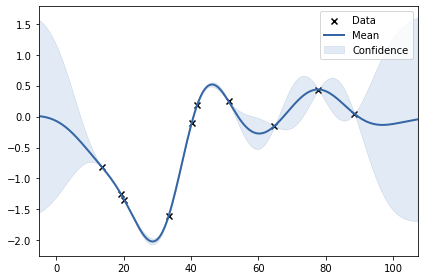

In [4]:
X = np.random.random((10,1))*100
Y = test_f(X)

Q = GPy.kern.RBF(input_dim=1, ARD=True)
model = GPy.models.GPRegression(X, Y, Q)
model.optimize_restarts(5);
model.plot()

In [11]:
import core.GPyOpt
from core.acquisition.Hybrid_continuous_KG_v2 import KG

ModuleNotFoundError: No module named 'GPyOpt'